In [1]:
#Script to determine and compare amino acid decomposition of the CDRs
#@Author: Henriette Capel
#@Date: 17-03-2022

In [1]:
#Import modules
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import ast
from ABDB import database as db
#from scalop.predict import assign
from sklearn import metrics
#import logomaker as lm
#%load_ext nb_black

/Users/gemmagordon/opt/anaconda3/lib/python3.8/site-packages/Bio/SubsMat/__init__.py:126: BiopythonDeprecationWarning: Bio.SubsMat has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.substitution_matrices as a replacement, and contact the Biopython developers if you still need the Bio.SubsMat module.
  warnings.warn(


In [2]:
#Constants
binning_scheme = {
  'D':'F','E':'F','H':'E','K':'E','R':'E',
  'I':'A','L':'A','M':'C','P':'A','V':'A',
  'N':'G','Q':'G','C':'C','S':'D','T':'D',
  'A':'A','G':'A','F':'B','W':'B','Y':'B'
}

#Create colour palette for the amino acids
colour_palette_aa_group = {'A': 'lightgreen',
                          'B': 'mediumpurple',
                          'C': 'yellow',
                          'D': 'orange',
                          'E': 'blue',
                          'F': 'tomato',
                          'G': 'tab:cyan'}

dict_letter_to_number = {"A": 0, 
                        "B": 1, 
                        "C": 2, 
                        "D":3, 
                        "E": 4,
                        "F": 5,
                        "G":6}

db.set_numbering_scheme('imgt')

In [3]:
#Functions
def read_dataset(filename_ds):
    
    df = pd.read_csv(filename_ds, converters={i: str for i in range(100)})
    
    for colname in df.columns.values.tolist():
        try:
            df[colname] = [ast.literal_eval(d) for d in df[colname]]
        except:
            pass

    return df
    
def add_decomposition_to_df(df : pd.DataFrame, cdrs: list[str], binning_scheme: dict[str,str]) -> pd.DataFrame:
    df_selection = df[['pdb', 'antigen_chain', 'antibody_chain', 'cdr_sequence']]
    cdr_seq_column = df_selection.cdr_sequence
    for cdr_type in cdrs:
        list_cdr = []
        list_aa_group = []
        
        #Extract cdr sequence out of dictionary
        for dict_cdr in cdr_seq_column:
            list_cdr.append(dict_cdr[cdr_type])
        df_selection.loc[:,f'{cdr_type}_sequence'] = list_cdr
        
        #Determine the group of the residue (amino acid)
        for cdr_seq in list_cdr:
            aa_group_seq = determine_aa_group(cdr_seq, binning_scheme)
            list_aa_group.append(aa_group_seq)
        df_selection.loc[:,f'{cdr_type}_group_sequence'] = list_aa_group
    
    return df_selection

def determine_aa_group(sequence, binning_scheme):
    aa_group_seq = ''
    for residue in sequence:
        aa_group_seq += binning_scheme[residue]
    return aa_group_seq

def determine_occurence_aa_group(df, cdrs, fraction: bool = False):
    dict_cdr_groups = {}
    for cdr_type in cdrs: 
        dict_aa_groups_sumarized = {}
        dict_groups_listed = store_occurence_aa_group_lists(df, cdr_type, fraction)
        total_number_residues = count_number_residues(dict_groups_listed)
        for aa_group in dict_groups_listed.keys():
            if fraction == True: #Take average over the fractions
                result = sum(dict_groups_listed[aa_group])/len(dict_groups_listed[aa_group])
                dict_aa_groups_sumarized[aa_group] = result
            else: #sum all residues per aa type and divide by total number of residues in the cdr_type sequences
                result = sum(dict_groups_listed[aa_group])/total_number_residues
                dict_aa_groups_sumarized[aa_group] = result
        dict_cdr_groups[cdr_type] = dict_aa_groups_sumarized
    return dict_cdr_groups
                
def count_number_residues(dict_groups_listed):
    count = 0
    for group_type in dict_groups_listed.keys():
        count += sum(dict_groups_listed[group_type])
    return count
    
def store_occurence_aa_group_lists(df, cdr_type, fraction = False):
    dict_groups= {'A': [],
                 'B': [],
                 'C': [],
                 'D': [],
                 'E': [],
                 'F': [],
                 'G': []}
    column_aa_group_cdrtype = df[f'{cdr_type}_group_sequence'].to_list()
    for sequence in column_aa_group_cdrtype:
        dict_group_counter = {'A': 0, 'B': 0, 'C': 0, 'D': 0, 'E': 0, 'F': 0, 'G': 0}
        for residue in sequence:
            dict_group_counter[residue] += 1
        for aa_group in dict_group_counter.keys():
            if fraction == True:
                dict_groups[aa_group].append(dict_group_counter[aa_group]/len(sequence))
            else:
                dict_groups[aa_group].append(dict_group_counter[aa_group])
    return dict_groups

def plot_aa_decomposition(dict_cdr_groups, ab_type, color, fraction=False):
    for cdr_type in dict_cdr_groups.keys():
        xnames = list(dict_cdr_groups[cdr_type].keys())
        yvalues = list(dict_cdr_groups[cdr_type].values())

        fig = plt.figure()
        ax = fig.add_axes([0,0,1,1])
        rects1 = ax.bar(xnames, yvalues, color = color)
        if fraction == True:
            plt.ylabel("Average fraction residue type per sequence")
        else:
            plt.ylabel("Average fraction residue type over all sequences")
        plt.title(f"{ab_type} antibody dataset, {cdr_type}")
        plt.show()

def plot_aa_decompo_2ds(dict_cdr_occur_1, dict_cdr_occur_2, ab_type1, ab_type2, color1, color2, fraction=False):
    #x = np.arange(len(xnames2))
    width = 0.45
    for cdr_type in dict_cdr_occur_1.keys():
        xnames1 = list(dict_cdr_occur_1[cdr_type].keys())
        yvalues1 = list(dict_cdr_occur_1[cdr_type].values())
        xnames2 = list(dict_cdr_occur_2[cdr_type].keys())
        yvalues2 = list(dict_cdr_occur_2[cdr_type].values())

        fig, ax = plt.subplots()
        rects1 = ax.bar(xnames1, yvalues1, -width, align='edge', color = color1, label = ab_type1)
        rects2 = ax.bar(xnames2, yvalues2, +width, align='edge', color = color2, label = ab_type2)
        if fraction == True:
                plt.ylabel("Average fraction residue type per sequence")
        else:
            plt.ylabel("Average fraction residue type over all sequences")
        plt.ylabel("Percentage occuring")
        plt.xticks(rotation=90)
        plt.legend()
        plt.title(f"{cdr_type}")
        plt.show()
        
#Make stacked plot per IMGT position
def decomposition_per_imgt_position(df, cdrs, binning_scheme):
    #Determine the amino acid decomposition per imgt numbering. 
    #Used the build in fab.get_cdr_sequence() in the ABDB database
    #Note: cdrs should be a list of the cdr types, for example ['CDRH1', 'CDRH2', 'CDRH3']
    df_selection = df[['pdb', 'antigen_chain', 'antibody_chain', 'cdr_sequence']]
    
    cdr_position_type_dict = {}
    for cdr_type in cdrs:
        cdr_position_type_dict[cdr_type] = {}
        
    cdr_position_type_dict = store_cdr_position_typelist_dict(df_selection, cdr_position_type_dict, binning_scheme, cdrs)
    cdr_position_count_dict = store_cdr_position_type_count_dict(cdr_position_type_dict)
    group_occurence_info_dict = transform_dict_to_stacked_format(cdr_position_count_dict, binning_scheme)

    return group_occurence_info_dict, cdr_position_type_dict
    
def store_cdr_position_typelist_dict(df, cdr_position_type_dict, binning_scheme, cdr_interest):
    #This function determines the cdr by reading the ABDB database.
    #the result is a nested dictionary which contains for each cdr_type the poisition as a key and the amino acid observed in a list
    #We filtered positions out of the dictionary of they were observed less than half of the sequencess
    for index, row in df.iterrows():
        pdb_id = row['pdb']
        ab_chain = row['antibody_chain']
        
        p = db.fetch(pdb_id)
        for fab in p.get_fabs():
            fab_chain_id = str(fab).split("\n")[0].split(" ")[1]#construct chain out of fab
            if fab_chain_id == ab_chain:
                result_get_cdrs = fab.get_CDR_sequences(definition = 'imgt', scheme = 'imgt')
                #for cdr_type in result_get_cdrs.keys():
                for cdr_type in cdr_interest:
                    info_list = result_get_cdrs[cdr_type]
                    for element in info_list:
                        imgt_position = element[0][0]
                        amino_acid = element[1]
                        aa_group = list(binning_scheme[amino_acid])
                        try: 
                            cdr_position_type_dict[cdr_type][imgt_position] = cdr_position_type_dict[cdr_type][imgt_position] + aa_group
                        except: #if it is the first time storing to this list
                            cdr_position_type_dict[cdr_type][imgt_position] = []
                            cdr_position_type_dict[cdr_type][imgt_position] = cdr_position_type_dict[cdr_type][imgt_position] + aa_group
                            
    #Check for positions which are only occuring a few times in the dataset. 
    #Remove positions which occur in less than halve of the sequences
    cdr_position_type_dict_filtered = {}
    for cdr in cdr_position_type_dict.keys():
        dict_position_aalist = {}
        for position in cdr_position_type_dict[cdr].keys():
            if len(cdr_position_type_dict[cdr][position]) >= df.shape[0]/2:
                dict_position_aalist[position] = cdr_position_type_dict[cdr][position]
            else:
                print(f"Position {position} is removed because this position was less than halve of the possible times observed, namely only {len(cdr_position_type_dict[cdr][position])}/{df.shape[0]} times")
        cdr_position_type_dict_filtered[cdr] = dict_position_aalist
    
    return cdr_position_type_dict_filtered

# def get_max_list_length(dict_position_list):  
#     #Determine the maximum length of all list which are the values of a dictionary
#     maks=max(dict_position_list, key=lambda k: len(dict_position_list[k]))
#     return len(dict_position_list[maks])

def store_cdr_position_type_count_dict(dict_cdr_position_type):
    #this function reads a dictionary that contains per CDR a list of amino acids that are observed in a certain position, 
    #and outputs a dictionary that contains per CDR per position a dictionary containing the amino acid class as key and the fraction of times observed as value 
    cdr_position_count_dict = {}
    for cdr_type in dict_cdr_position_type.keys():
        position_count_dict = {}
        for position in dict_cdr_position_type[cdr_type]:
            list_aa_types = dict_cdr_position_type[cdr_type][position]
            d = {item:list_aa_types.count(item) for item in list_aa_types}
            d_fraction = {k: v / total for total in (sum(d.values()),) for k, v in d.items()}
            position_count_dict[position] = d_fraction
        cdr_position_count_dict[cdr_type] = position_count_dict
    return cdr_position_count_dict

def transform_dict_to_stacked_format(cdr_position_count_dict, binning_scheme):
    #This function reads a dictionary that contains per CDR per position a dictionary containing the amino acid class as key and the fraction of times observed as value,
    #and outputs a dictionary containt per CDR a dictionary of the amino acid type as key and a list of fractions as value. the order of the fractions is stored in the key "positions". 
    
    dict_cdr_plottinginfo = {}

    for cdr_type in cdr_position_count_dict.keys():
        #Set up empty dictionary
        dict_aa_group = {}
        list_aa_groupnames = list(set(binning_scheme.values()))
        for aa_groupname in list_aa_groupnames:
            dict_aa_group[aa_groupname] = []
            
        labels_list = list(cdr_position_count_dict[cdr_type].keys())
        dict_aa_group['positions'] = labels_list
        
        for position in cdr_position_count_dict[cdr_type].keys():
            for aa_group in list_aa_groupnames: #Need to store if occurence is 0.0
                try: 
                    dict_aa_group[aa_group].append(cdr_position_count_dict[cdr_type][position][aa_group])
                except:
                    dict_aa_group[aa_group].append(0.0)
        dict_cdr_plottinginfo[cdr_type] = dict_aa_group
    return dict_cdr_plottinginfo


def plot_stacked_aa_decompo(dict_cdr_plottinginfo, binning_scheme, colour_palette, ab_type, number_seq = False):
    list_aa_groupnames = sorted(list(set(binning_scheme.values())))
    
    for cdr_type in dict_cdr_plottinginfo.keys():
        df = pd.DataFrame(dict_cdr_plottinginfo[cdr_type])
        df = df.sort_values(by="positions", ascending=True) #Order based on the position number
        fig, ax = plt.subplots()
        
        labels = df["positions"]
        labels_str = [str(x) for x in labels] 
        bottom_value = np.zeros(len(labels))
        for aa_group in list_aa_groupnames:
            yvalues = df[aa_group]
            ax.bar(labels_str, yvalues, label=aa_group, color=colour_palette[aa_group], bottom=bottom_value)
            bottom_value = bottom_value + yvalues
        ax.set_xticklabels(labels_str)
        ax.set_ylabel('Fraction occurence')
        
        if number_seq:
            ax.set_title(f'{ab_type}, number sequences: {number_seq}')
        else:
            ax.set_title(f'{ab_type}: {cdr_type}')
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.show()
    
def plot_difference(dict_info_ds1, dict_info_ds2, cdrs_to_compare, binning_scheme, colour_palette, figure_title, canonical_form = False, num_seq= False):
    list_aa_groupnames = sorted(list(set(binning_scheme.values()))) 
    
    for cdr_type in cdrs_to_compare:
        df1 = pd.DataFrame(dict_info_ds1[cdr_type])
        df1 = df1.sort_values(by="positions", ascending=True) #Order based on the position number
        df1 = df1.set_index('positions')
        
        df2 = pd.DataFrame(dict_info_ds2[cdr_type])
        df2 = df2.sort_values(by="positions", ascending=True) #Order based on the position number
        df2 = df2.set_index('positions')
        
        df_difference = df1.subtract(df2)

        labels = list(df_difference.index.values)
        labels_str = [str(x) for x in labels] 
        
        fig = plt.figure()
        ax1 = fig.add_subplot(111)

        for aa_group in list_aa_groupnames:
            ax1.scatter(labels_str, df_difference[aa_group], c=colour_palette[aa_group], label=aa_group)
            plt.plot(labels_str, df_difference[aa_group], c=colour_palette[aa_group])

        ax1.set_xticklabels(labels_str)
        ax1.set_ylim([-1.0, 1.0])
        ax1.set_ylabel('Difference fraction occurence')
        ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        if canonical_form and num_seq:
            ax1.set_title(f'{figure_title}: {canonical_form}: ({num_seq[0]},{num_seq[1]})')
        elif canonical_form:
            ax1.set_title(f'{figure_title}: {canonical_form}')
        else: 
            ax1.set_title(f'{figure_title}: {cdr_type}')
        
        plt.show()
        
    return df_difference

def plot_differences_stacked(dict_info_ds1, dict_info_ds2, cdrs_to_compare, binning_scheme, colour_palette, figure_title, dict_position_mutualinfoscore=False, canonical_form = False, num_seq= False):
    #This function determines the differences between the two datasets and visualises the results
    
    #list_aa_groupnames = list(set(binning_scheme.values())) #Do not sort the list, will loose values-class information
    
    for cdr_type in cdrs_to_compare:
        np_differences, df_difference, data_stack, data_shape, order_aagroups = setup_data_plot_difference_stacked(dict_info_ds1, dict_info_ds2, cdr_type)
        plotting_differences_stacked(np_differences, df_difference, data_stack, data_shape, order_aagroups, cdr_type, colour_palette, figure_title, dict_position_mutualinfoscore, canonical_form, num_seq)
        
    return df_difference
        
def setup_data_plot_difference_stacked(dict_info_ds1, dict_info_ds2, cdr_type):
    #This function represents the dictionary of a specific cdr_type containing a dictionary with the amino acid type as keys and list of fractions of occurence in the different positions as values. the order of these positions is stored in the key "positions".
    #For each position and each amino acid type the difference between the single domain antibodies and the full length antibodies is calculated.
    
    #Store dictionary in dataframe
    df1 = pd.DataFrame(dict_info_ds1[cdr_type])
    df1 = df1.sort_values(by="positions", ascending=True) #Order based on the position number
    df1 = df1.set_index('positions')

    df2 = pd.DataFrame(dict_info_ds2[cdr_type])
    df2 = df2.sort_values(by="positions", ascending=True) #Order based on the position number
    df2 = df2.set_index('positions')
    
    #Determine difference between df1 and df2
    df_difference = df1.subtract(df2)
    df_difference.dropna(inplace=True)
    
    #Set to numpy to make plot creation easier
    df_transpose = df_difference.T
    np_differences = df_transpose.to_numpy()
    order_aagroups = list(df_difference.columns)

    data_shape = np.shape(np_differences)

    # Take negative and positive data apart and cumulate
    cumulated_data = get_cumulated_array(np_differences, min=0)
    cumulated_data_neg = get_cumulated_array(np_differences, max=0)

    # Re-merge negative and positive data.
    row_mask = (np_differences<0)
    cumulated_data[row_mask] = cumulated_data_neg[row_mask]
    data_stack = cumulated_data
    
    return np_differences, df_difference, data_stack, data_shape, order_aagroups

def determine_mutual_info_score(dict_1, dict_2, dict_letter_to_number):
    dict_position_scores = {}
    
    cdr_type = list(dict_1.keys())[0] #Note always one key
    if len(list(dict_1.keys())) >1:
        print("Warning: more keys in dictionary")
    
    #Do only for similar positions
    list_positions_1 = list(dict_1[cdr_type].keys())
    list_positions_2 = list(dict_2[cdr_type].keys())
    similar_positions = list(set(list_positions_1) & set(list_positions_2))
    
    for position in similar_positions:
        list_letters_1 = dict_1[cdr_type][position]
        list_numbers_1 = convert_letter_to_number(list_letters_1, dict_letter_to_number)
        list_class_1 = [0]*len(list_numbers_1)
        
        list_letters_2 = dict_2[cdr_type][position]
        list_numbers_2 = convert_letter_to_number(list_letters_2, dict_letter_to_number)
        list_class_2 = [1]*len(list_numbers_2)
        
        #Combine to make input for mutual information score function
        list_classes = list_class_1 + list_class_2
        list_aa_group = list_numbers_1 + list_numbers_2
        
        #score = metrics.mutual_info_score(list_aa_group, list_classes)
        score = metrics.adjusted_mutual_info_score(list_aa_group, list_classes)
        dict_position_scores[position] = score
    return dict_position_scores
        
def convert_letter_to_number(list_letters, dict_letter_to_number):
    list_numbers = [dict_letter_to_number.get(item,item)  for item in list_letters]
    return list_numbers

def plotting_differences_stacked(np_differences, df_difference, data_stack, data_shape, list_aa_groupnames, cdr_type, colour_palette, figure_title, dict_position_mutualinfoscore, canonical_form, num_seq):
    labels = list(df_difference.index.values)
    labels_str = [str(x) for x in labels] 

    fig = plt.figure()
    ax = plt.subplot(111)
    
    #order the amino acids groups such that always the same order in all different plots
    #Need copy first because .sort() will overwrite the list and we still need to be able to access the old order
    order_list_aa_groupnames = list_aa_groupnames.copy()
    order_list_aa_groupnames.sort()
    
    dict_description_AA_class = {"A": "aliphatic", "B": "aromatic", "C": "sulfur", "D": "hydroxyl", "E": "basic", "F": "acidic", "G": "amine"}
    
    # for i in np.arange(0, data_shape[0]):
    #     bar = ax.bar(labels_str, np_differences[i], bottom=data_stack[i], color=colour_palette[list_aa_groupnames[i]], label = list_aa_groupnames[i])
    for aa in order_list_aa_groupnames:
        #Assign the right index for np_differences and data_stack
        index = list_aa_groupnames.index(aa)
        bar = ax.bar(labels_str, np_differences[index], bottom=data_stack[index], color=colour_palette[aa], label = f"{aa}: {dict_description_AA_class[aa]}")
        
    if dict_position_mutualinfoscore: #Add the mutual information score if provided 
        y_offset = 0.02
        for i in range(len(bar)):
            position = labels_str[i]
            try:
                score = dict_position_mutualinfoscore[int(position)]
                
                #Height of the text is the sum over all positive values in the corresponding row in the dataframe 
                list_scores_per_position = df_difference.loc[int(position)].tolist()
                height_stacked_bar = positive_sum(list_scores_per_position)
                plt.text(bar[i].get_x() + bar[i].get_width() / 2.0, height_stacked_bar + y_offset, f'{score:.2f}', ha='center', va='bottom')
            except KeyError: #position does not exist
                pass 
    
    ax.set_xticklabels(labels_str)
    ax.set_xlabel("CDR IMGT position")
    ax.set_ylabel('Difference of observed fractions')
    ax.set_ylim([-1.2, 1.2])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    if canonical_form and num_seq:
        ax.set_title(f'{figure_title}: {canonical_form}: ({num_seq[0]},{num_seq[1]})')
    elif canonical_form:
        ax.set_title(f'{figure_title}: {canonical_form}')
    else: 
        ax.set_title(f'{figure_title}: {cdr_type}')
    plt.show()
    # plt.savefig(f'aa_decomp_{cdr_type}_{canonical_form}.png', bbox_inches='tight')
    
    
def positive_sum(list_differences):
    s = 0 
    for x in list_differences:
        if x > 0:
            s = s + x
    return s
    
def get_cumulated_array(data, **kwargs):
    #Function needed to make stacked difference plot
    cum = data.clip(**kwargs)
    cum = np.cumsum(cum, axis=0)
    d = np.zeros(np.shape(data))
    d[1:] = cum[:-1]
    return d 

# #decomposition per canonicalf form. 
def canonical_form_aa_decomp(df_with_decomp):
    dict_cdr_canonical = {'pdb': [],
                          'H1': [],
                          'H2': []}
    
    for index, row in df_with_decomp.iterrows():
        pdb_id = row['pdb']
        ag_chain = row['antigen_chain']
        ab_chain = row['antibody_chain']
        
        dict_cdr_canonical['pdb'].append(pdb_id)
        
        p = db.fetch(pdb_id)
        for fab in p.get_fabs():
            fab_chain_id = str(fab).split("\n")[0].split(" ")[1]#construct chain out of fab
            if fab_chain_id == ab_chain:
                seq_result = fab.get_sequence()
                heavy_chain_seq = seq_result.split("/")[0]
                out_scalop = assign(heavy_chain_seq, scheme= 'imgt', definition='imgt')
                for result in out_scalop:
                    if len(result) != 0:
                        for cdr_type in list(dict_cdr_canonical.keys())[1:]:
                            canonical_form = result['outputs'][cdr_type][2]
                            dict_cdr_canonical[cdr_type].append(canonical_form)
    #Combine data                            
    df_canonical = pd.DataFrame(dict_cdr_canonical)
    df_canonical.columns = ['pdb_check', 'CDRH1_canonicalform', 'CDRH2_canonicalform']
  
    df_decomp_canonical = pd.concat([df_with_decomp, df_canonical], axis=1)
    if df_decomp_canonical['pdb'].equals(df_decomp_canonical['pdb_check']):
        df_decomp_canonical.drop(['pdb_check'], axis=1)
    else:
        print("WARNING: concatenating dataframes incorrect")

    return df_decomp_canonical

#Check cdr imgt positions per canonical class 
def print_cdrs_per_canonical_class(df_decomp_canonical, df_ds, cdr_type, canonical_form):
    df_canonical = df_decomp_canonical[df_decomp_canonical[f'{cdr_type}_canonicalform'] == canonical_form]
    #column_pdbs = df_canonical['pdb'].tolist()
    print(f"Total number of sequences belonging to this class {df_canonical.shape[0]}")
    
    total_num_F = 0
    total_num_Y = 0
    
    for index,row in df_canonical.iterrows():
        #selected_row = df_ds.loc[df_ds['pdb'] == pdb_id]
        pdb_id = row['pdb']
        ag_chain = row['antigen_chain']
        ab_chain = row['antibody_chain']

        p = db.fetch(pdb_id)
        for fab in p.get_fabs():
            fab_chain_id = str(fab).split("\n")[0].split(" ")[1]#construct chain out of fab
            if fab_chain_id == ab_chain:
                result_imgt = fab.get_CDR_sequences(definition = 'imgt', scheme = 'imgt')
                for position in result_imgt[cdr_type]:
                    if str(position[0][0]) == "28":
                        if str(position[1]) == "F":
                            total_num_F += 1
                        elif str(position[1]) == "Y":
                            total_num_Y += 1
                        else:
                            pass
    print(f"F: {total_num_F}")
    print(f"Y: {total_num_Y}")
    
def make_sequence_logo(dict_cdr_plottinginfo, binning_scheme, colour_palette_aa_group):
    #Function to make sequence logo figure of a dataframe in which for each position the fraction of all amino acid (classes) are stored
    
    for cdr_type in dict_cdr_plottinginfo.keys():
        df = pd.DataFrame(dict_cdr_plottinginfo[cdr_type])
        df_info = df.sort_values(by="positions", ascending=True) #Order based on the position number
        list_positions = list(df_info['positions'])
    
        #set index; such that only these positions in plot instead of min-max
        df_info = df_info.reset_index()

        #Convert NAN to 0.0
        df_info = df_info.fillna(0.0)

        #Make figure
        logo = lm.Logo(df_info[sorted(list(set(binning_scheme.values())))], color_scheme = colour_palette_aa_group, stack_order='small_on_top', font_name = 'Arial Rounded MT Bold')

        #Improve figure
        #Give the right labels to plot
        logo.ax.set_xticks(range(len(df_info)))
        logo.ax.set_xticklabels(x for x in list_positions) 
        logo.ax.set_ylabel("Normalised frequency", fontsize = 12)
        logo.ax.set_xlabel("IMGT positions", fontsize = 12)
        
        # plt.savefig(f'seqlogo_fv_{cdr_type}.png', bbox_inches='tight')

    

TypeError: 'type' object is not subscriptable

In [ ]:
#Single domain antibodies
ds_name_nb = "Dataset_nb_filtered.csv"
cdrs_present_nb = ['CDRH1', 'CDRH2', 'CDRH3', 'CDRH']

df_nb = read_dataset(ds_name_nb)
df_cdrs_decompo_nb = add_decomposition_to_df(df_nb, cdrs_present_nb, binning_scheme)
dict_cdr_groups_nb = determine_occurence_aa_group(df_cdrs_decompo_nb, cdrs_present_nb, fraction = False)
dict_cdr_groups_fraction_nb = determine_occurence_aa_group(df_cdrs_decompo_nb, cdrs_present_nb, fraction = True)

/tmp/ipykernel_3106984/3897421366.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selection.loc[:,f'{cdr_type}_sequence'] = list_cdr
/tmp/ipykernel_3106984/3897421366.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selection.loc[:,f'{cdr_type}_group_sequence'] = list_aa_group
/tmp/ipykernel_3106984/3897421366.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

<IPython.core.display.Javascript object>

In [ ]:
# #plot amino acid decomposition
plot_aa_decomposition(dict_cdr_groups_nb, "Single domain" , 'royalblue', fraction = True)

<IPython.core.display.Javascript object>

In [ ]:
# #plot amino acid decomposition
plot_aa_decomposition(dict_cdr_groups_nb, "Single domain" , 'royalblue', fraction = False)

<IPython.core.display.Javascript object>

In [ ]:
#Full length antibodies
ds_name_fv = "Dataset_fv_filtered.csv"
cdrs_present_fv = ['CDRH1', 'CDRH2', 'CDRH3', 'CDRH', 'CDRL1', 'CDRL2', 'CDRL3', 'CDRL', 'CDRHL']

df_fv = read_dataset(ds_name_fv)
df_cdrs_decompo_fv = add_decomposition_to_df(df_fv, cdrs_present_fv, binning_scheme)
dict_cdr_groups_fv = determine_occurence_aa_group(df_cdrs_decompo_fv, cdrs_present_fv, fraction = False)
dict_cdr_groups_fraction_fv = determine_occurence_aa_group(df_cdrs_decompo_fv, cdrs_present_fv, fraction = True)

/tmp/ipykernel_3106984/3897421366.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selection.loc[:,f'{cdr_type}_sequence'] = list_cdr
/tmp/ipykernel_3106984/3897421366.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selection.loc[:,f'{cdr_type}_group_sequence'] = list_aa_group
/tmp/ipykernel_3106984/3897421366.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

<IPython.core.display.Javascript object>

In [ ]:
#### Amino acid decomposition per IMGT number

<IPython.core.display.Javascript object>

Position 31 is removed because this position was less than halve of the possible times observed, namely only 9/345 times
Position 32 is removed because this position was less than halve of the possible times observed, namely only 11/345 times
Position 33 is removed because this position was less than halve of the possible times observed, namely only 13/345 times
Position 34 is removed because this position was less than halve of the possible times observed, namely only 7/345 times
Position 60 is removed because this position was less than halve of the possible times observed, namely only 11/345 times
Position 61 is removed because this position was less than halve of the possible times observed, namely only 5/345 times


/tmp/ipykernel_3106984/3897421366.py:236: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels_str)


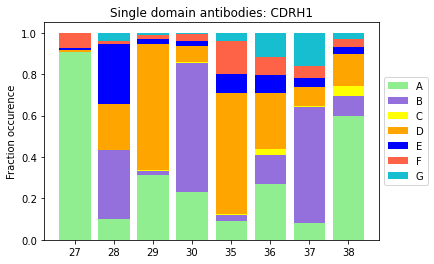

/tmp/ipykernel_3106984/3897421366.py:236: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels_str)


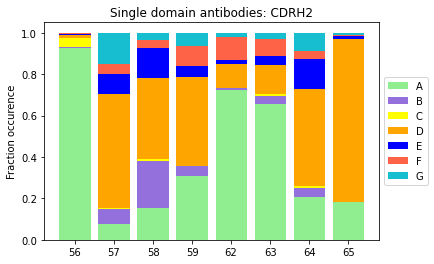

/tmp/ipykernel_3106984/3897421366.py:236: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels_str)


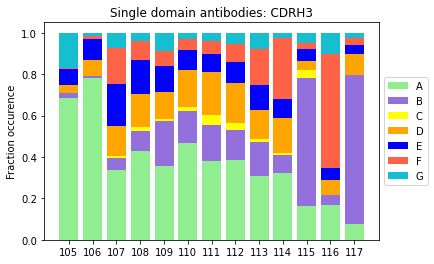

findfont: Font family ['Arial Rounded MT Bold'] not found. Falling back to DejaVu Sans.


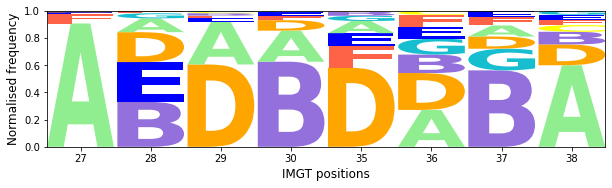

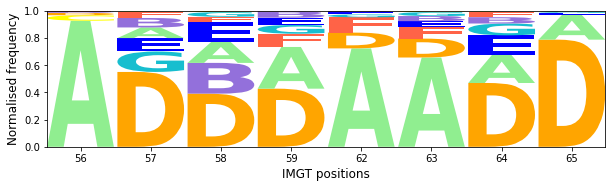

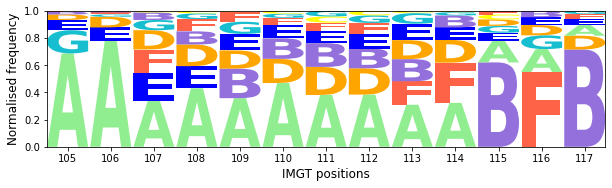

<IPython.core.display.Javascript object>

In [ ]:
#Single domain antibodies
ds_name_nb = "Dataset_nb_filtered.csv"
cdrs_interested = ['CDR-H1', 'CDR-H2', 'CDR-H3']

df_nb = read_dataset(ds_name_nb)
#Note: Average fraction residue type over all sequences
dict_stacked_info_nb, cdr_position_type_dict_nb = decomposition_per_imgt_position(df_nb, cdrs_interested, binning_scheme)
plot_stacked_aa_decompo(dict_stacked_info_nb, binning_scheme, colour_palette_aa_group, "Single domain antibodies")
make_sequence_logo(dict_stacked_info_nb, binning_scheme, colour_palette_aa_group)

Position 31 is removed because this position was less than halve of the possible times observed, namely only 95/892 times
Position 34 is removed because this position was less than halve of the possible times observed, namely only 64/892 times
Position 32 is removed because this position was less than halve of the possible times observed, namely only 10/892 times
Position 33 is removed because this position was less than halve of the possible times observed, namely only 14/892 times
Position 60 is removed because this position was less than halve of the possible times observed, namely only 34/892 times
Position 61 is removed because this position was less than halve of the possible times observed, namely only 28/892 times
Position 30 is removed because this position was less than halve of the possible times observed, namely only 338/892 times
Position 31 is removed because this position was less than halve of the possible times observed, namely only 205/892 times
Position 35 is removed

/tmp/ipykernel_3106984/3897421366.py:236: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels_str)


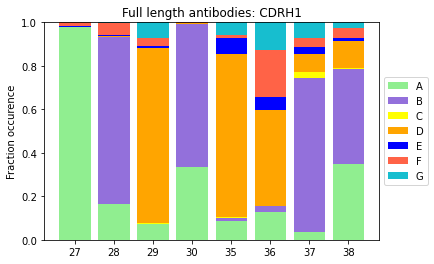

/tmp/ipykernel_3106984/3897421366.py:236: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels_str)


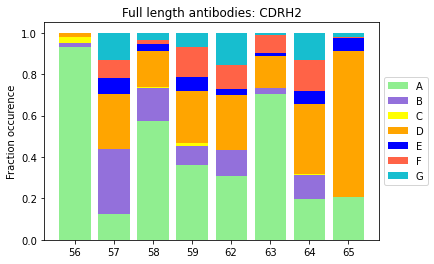

/tmp/ipykernel_3106984/3897421366.py:236: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels_str)


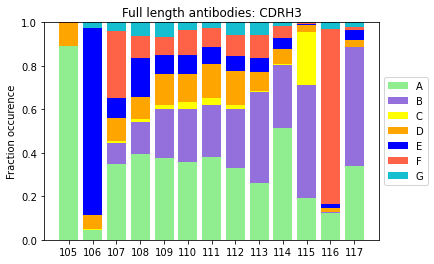

/tmp/ipykernel_3106984/3897421366.py:236: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels_str)


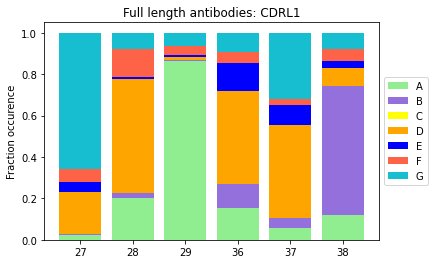

/tmp/ipykernel_3106984/3897421366.py:236: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels_str)


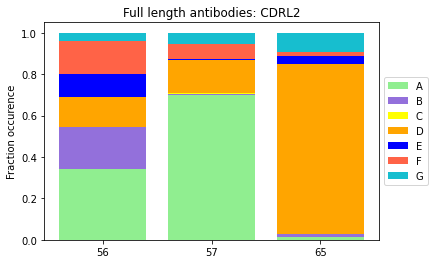

/tmp/ipykernel_3106984/3897421366.py:236: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels_str)


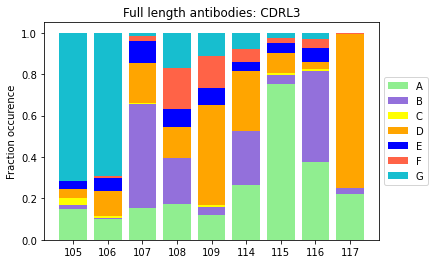

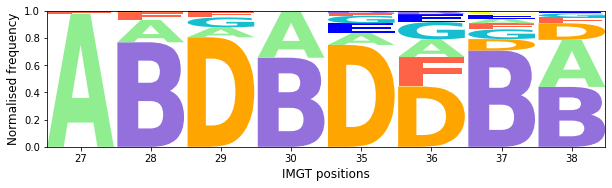

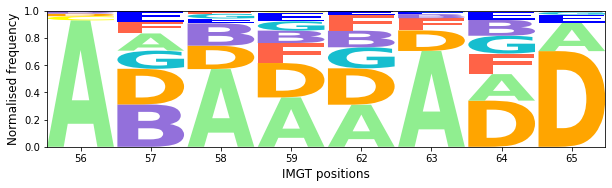

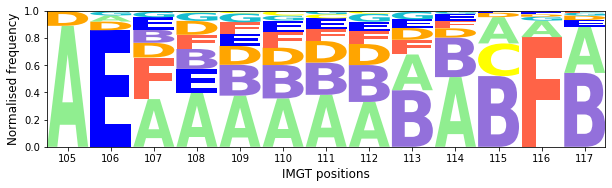

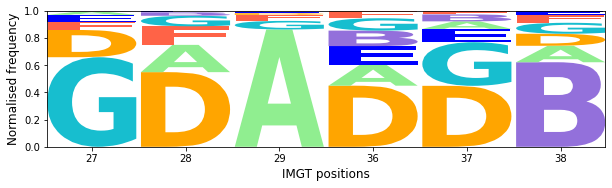

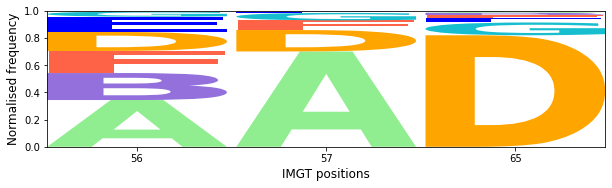

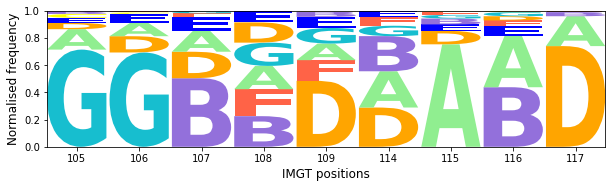

<IPython.core.display.Javascript object>

In [ ]:
#Full length antibodies
ds_name_fv = "Dataset_fv_filtered.csv"
cdrs_interested_fv = ['CDRH1', 'CDRH2', 'CDRH3', 'CDRL1', 'CDRL2', 'CDRL3']

df_fv = read_dataset(ds_name_fv)
#Note: Average fraction residue type over all sequences
dict_stacked_info_fv, cdr_position_type_dict_fv = decomposition_per_imgt_position(df_fv, cdrs_interested_fv, binning_scheme)
plot_stacked_aa_decompo(dict_stacked_info_fv, binning_scheme, colour_palette_aa_group, "Full length antibodies")
make_sequence_logo(dict_stacked_info_fv, binning_scheme, colour_palette_aa_group)

/tmp/ipykernel_3106984/3897421366.py:270: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(labels_str)


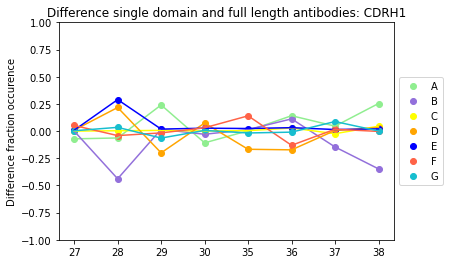

/tmp/ipykernel_3106984/3897421366.py:270: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(labels_str)


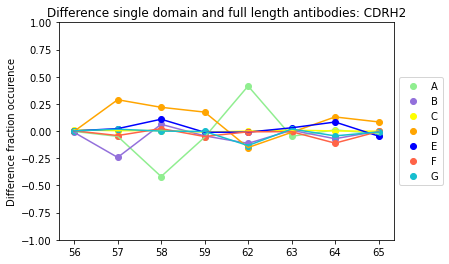

/tmp/ipykernel_3106984/3897421366.py:270: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(labels_str)


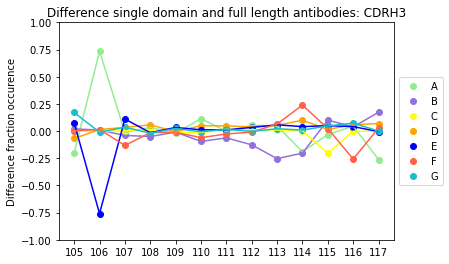

<IPython.core.display.Javascript object>

In [ ]:
#Plot difference ratio amino acids groups between single domain and full length antibodies
df_difference_nb_fv = plot_difference(dict_stacked_info_nb, dict_stacked_info_fv, ['CDRH1', 'CDRH2', 'CDRH3'], binning_scheme, colour_palette_aa_group, "Difference single domain and full length antibodies")

/tmp/ipykernel_3106984/3897421366.py:400: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels_str)


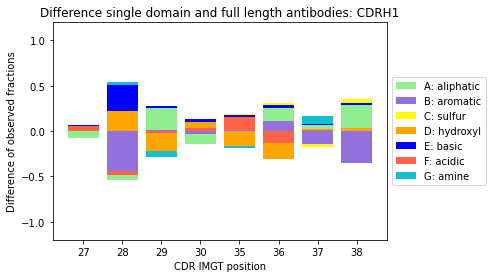

/tmp/ipykernel_3106984/3897421366.py:400: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels_str)


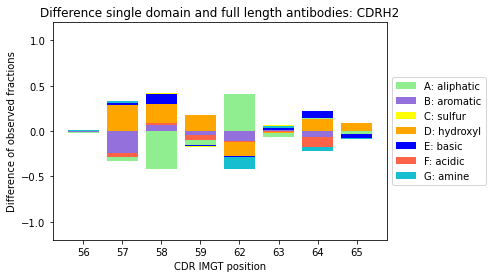

/tmp/ipykernel_3106984/3897421366.py:400: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels_str)


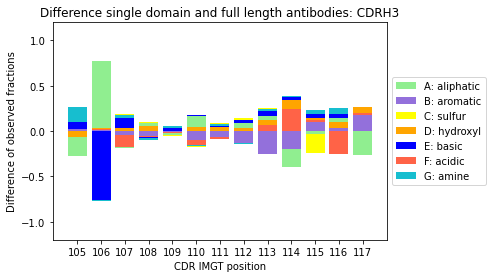

<IPython.core.display.Javascript object>

In [ ]:
#Plot differences as stacked plot
df_difference_nb_fv = plot_differences_stacked(dict_stacked_info_nb, dict_stacked_info_fv, ['CDRH1', 'CDRH2', 'CDRH3'], binning_scheme, colour_palette_aa_group, "Difference single domain and full length antibodies")

In [ ]:
#### Decomposition per canonical form, per imgt numbering

<IPython.core.display.Javascript object>

/tmp/ipykernel_3106984/3897421366.py:236: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels_str)


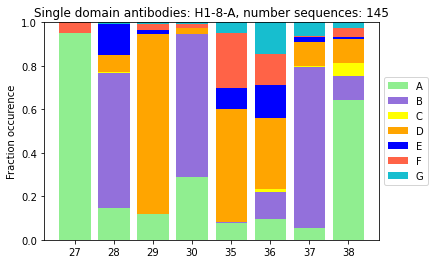

/tmp/ipykernel_3106984/3897421366.py:236: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels_str)


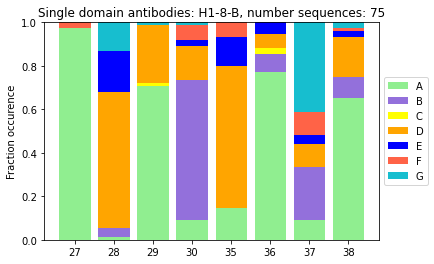

Position 31 is removed because this position was less than halve of the possible times observed, namely only 9/72 times
Position 32 is removed because this position was less than halve of the possible times observed, namely only 11/72 times
Position 33 is removed because this position was less than halve of the possible times observed, namely only 13/72 times
Position 34 is removed because this position was less than halve of the possible times observed, namely only 7/72 times


/tmp/ipykernel_3106984/3897421366.py:236: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels_str)


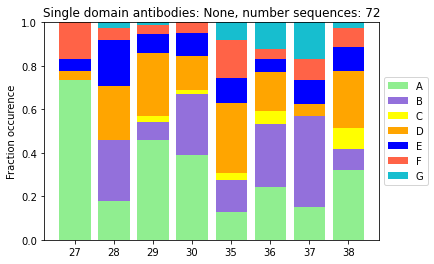

/tmp/ipykernel_3106984/3897421366.py:236: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels_str)


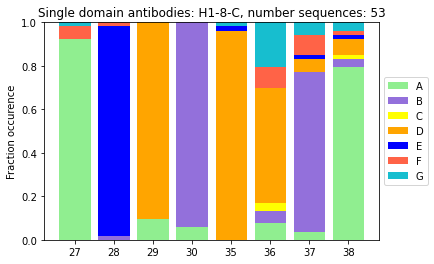

/tmp/ipykernel_3106984/3897421366.py:236: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels_str)


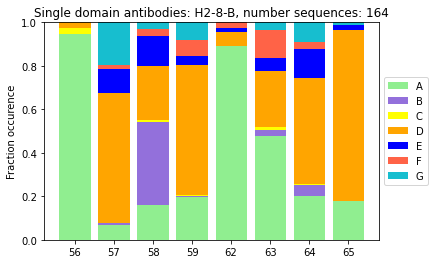

/tmp/ipykernel_3106984/3897421366.py:236: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels_str)


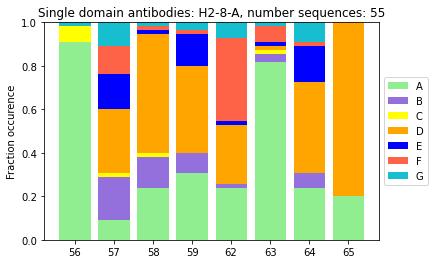

/tmp/ipykernel_3106984/3897421366.py:236: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels_str)


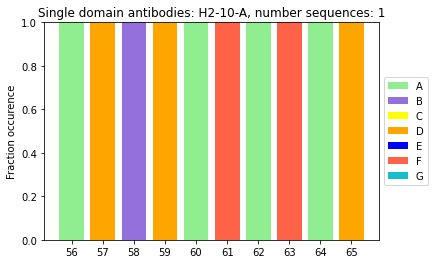

/tmp/ipykernel_3106984/3897421366.py:236: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels_str)


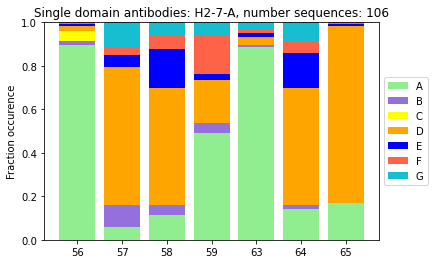

Position 61 is removed because this position was less than halve of the possible times observed, namely only 4/19 times


/tmp/ipykernel_3106984/3897421366.py:236: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels_str)


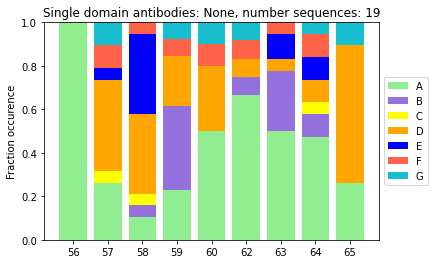

<IPython.core.display.Javascript object>

In [ ]:
#Single domain antibodies
cdrs_interest = ['CDRH1', 'CDRH2']

df_decomp_canonical_nb = canonical_form_aa_decomp(df_cdrs_decompo_nb)
for cdr_type in cdrs_interest:
    set_canonical_forms = set(df_decomp_canonical_nb[f'{cdr_type}_canonicalform'])
    for canonical_form in list(set_canonical_forms):
        df_canonical = df_decomp_canonical_nb[df_decomp_canonical_nb[f'{cdr_type}_canonicalform'] == canonical_form]
        number_sequences = df_canonical.shape[0]
        dict_stacked_info_cf, cdr_position_type_dict_cf_nb = decomposition_per_imgt_position(df_canonical, cdr_type.split(" "), binning_scheme)
        plot_stacked_aa_decompo(dict_stacked_info_cf, binning_scheme, colour_palette_aa_group, f"Single domain antibodies: {canonical_form}", number_seq = number_sequences)

/tmp/ipykernel_3106984/3897421366.py:236: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels_str)


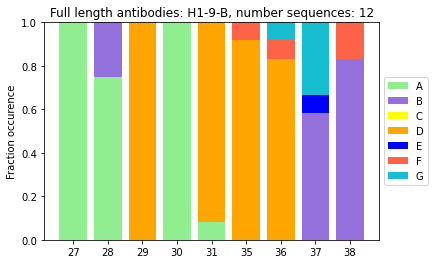

/tmp/ipykernel_3106984/3897421366.py:236: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels_str)


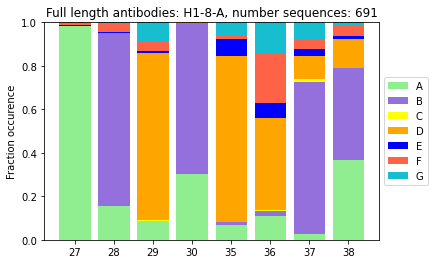

/tmp/ipykernel_3106984/3897421366.py:236: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels_str)


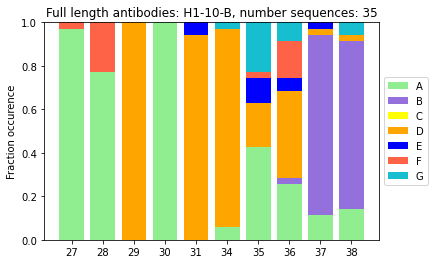

/tmp/ipykernel_3106984/3897421366.py:236: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels_str)


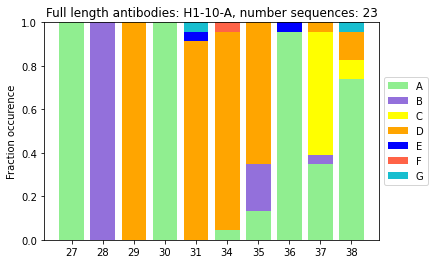

/tmp/ipykernel_3106984/3897421366.py:236: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels_str)


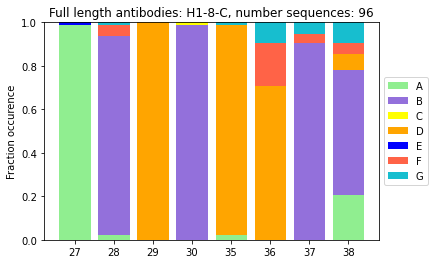

/tmp/ipykernel_3106984/3897421366.py:236: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels_str)


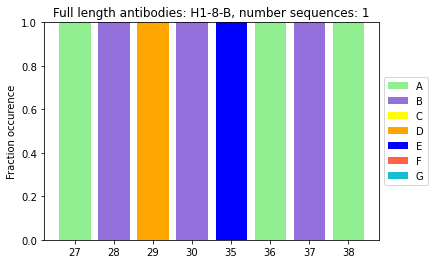

Position 34 is removed because this position was less than halve of the possible times observed, namely only 6/20 times


/tmp/ipykernel_3106984/3897421366.py:236: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels_str)


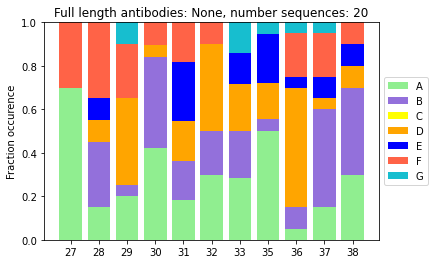

/tmp/ipykernel_3106984/3897421366.py:236: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels_str)


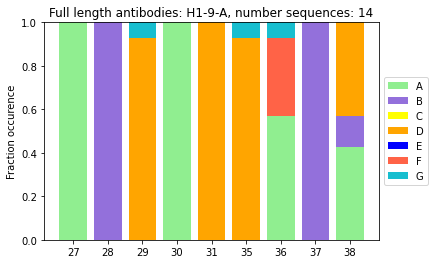

/tmp/ipykernel_3106984/3897421366.py:236: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels_str)


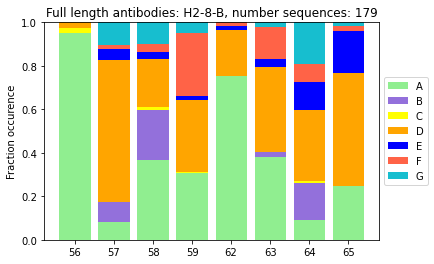

/tmp/ipykernel_3106984/3897421366.py:236: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels_str)


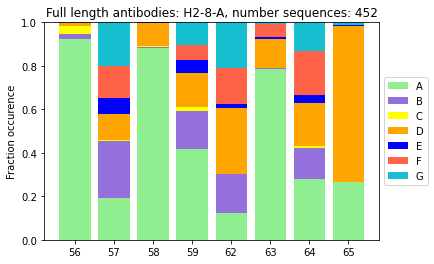

/tmp/ipykernel_3106984/3897421366.py:236: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels_str)


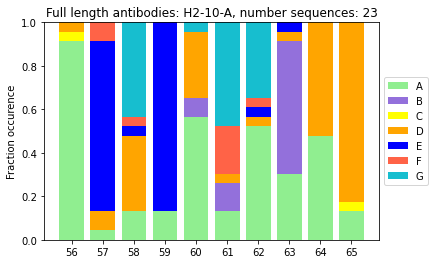

Position 62 is removed because this position was less than halve of the possible times observed, namely only 1/224 times


/tmp/ipykernel_3106984/3897421366.py:236: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels_str)


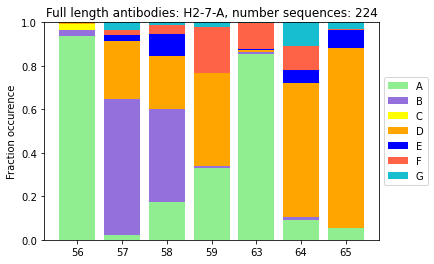

Position 61 is removed because this position was less than halve of the possible times observed, namely only 5/14 times


/tmp/ipykernel_3106984/3897421366.py:236: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels_str)


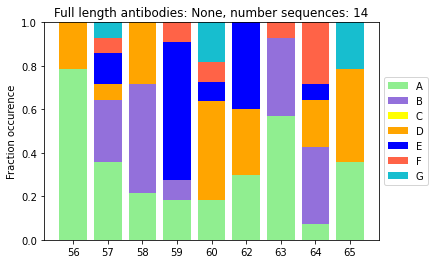

<IPython.core.display.Javascript object>

In [ ]:
#full length antibodies
cdrs_interest = ['CDRH1', 'CDRH2']

df_decomp_canonical_fv = canonical_form_aa_decomp(df_cdrs_decompo_fv)

for cdr_type in cdrs_interest:
    set_canonical_forms = set(df_decomp_canonical_fv[f'{cdr_type}_canonicalform'])
    for canonical_form in list(set_canonical_forms):
        df_canonical = df_decomp_canonical_fv[df_decomp_canonical_fv[f'{cdr_type}_canonicalform'] == canonical_form]
        dict_stacked_info_cf, cdr_position_type_dict_cf_fv = decomposition_per_imgt_position(df_canonical, cdr_type.split(" "), binning_scheme)
        number_sequences = df_canonical.shape[0]
        plot_stacked_aa_decompo(dict_stacked_info_cf, binning_scheme, colour_palette_aa_group, f"Full length antibodies: {canonical_form}", number_seq = number_sequences)

Position 31 is removed because this position was less than halve of the possible times observed, namely only 9/72 times
Position 32 is removed because this position was less than halve of the possible times observed, namely only 11/72 times
Position 33 is removed because this position was less than halve of the possible times observed, namely only 13/72 times
Position 34 is removed because this position was less than halve of the possible times observed, namely only 7/72 times
Position 34 is removed because this position was less than halve of the possible times observed, namely only 6/20 times


/tmp/ipykernel_3106984/3897421366.py:400: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels_str)


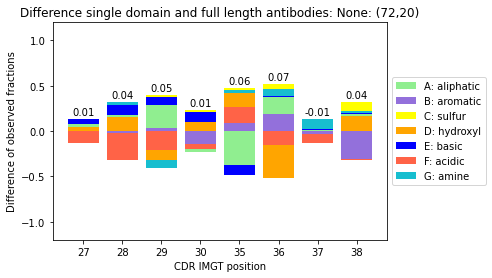

/tmp/ipykernel_3106984/3897421366.py:400: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels_str)


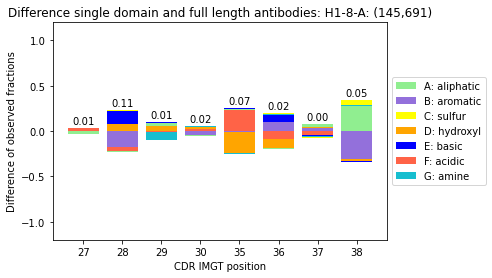

/tmp/ipykernel_3106984/3897421366.py:400: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels_str)


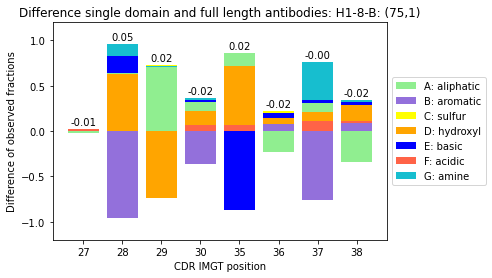

/tmp/ipykernel_3106984/3897421366.py:400: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels_str)


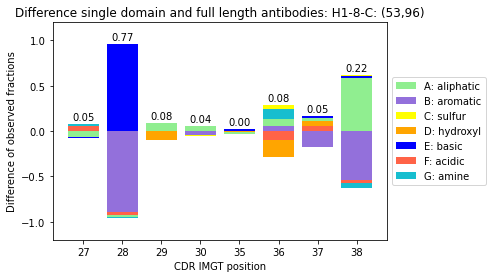

/tmp/ipykernel_3106984/3897421366.py:400: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels_str)


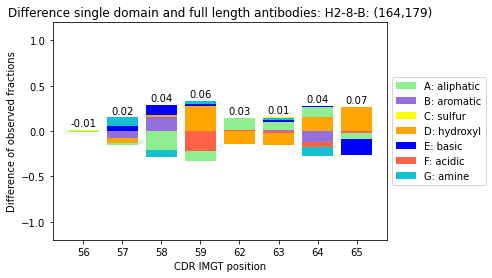

/tmp/ipykernel_3106984/3897421366.py:400: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels_str)


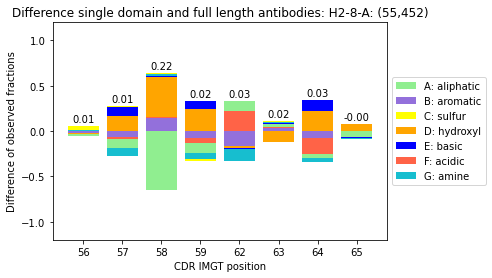

/tmp/ipykernel_3106984/3897421366.py:400: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels_str)


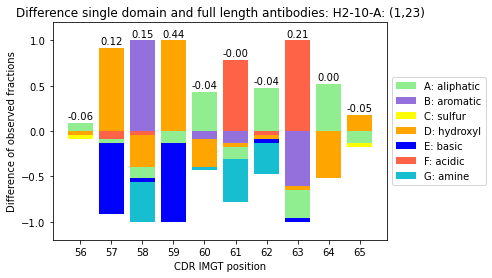

Position 62 is removed because this position was less than halve of the possible times observed, namely only 1/224 times


/tmp/ipykernel_3106984/3897421366.py:400: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels_str)


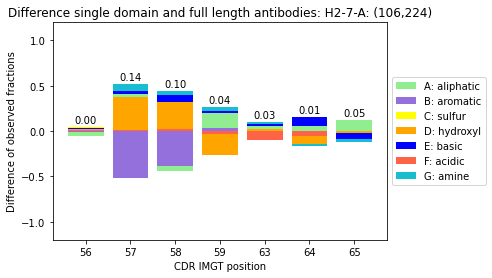

Position 61 is removed because this position was less than halve of the possible times observed, namely only 4/19 times
Position 61 is removed because this position was less than halve of the possible times observed, namely only 5/14 times


/tmp/ipykernel_3106984/3897421366.py:400: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels_str)


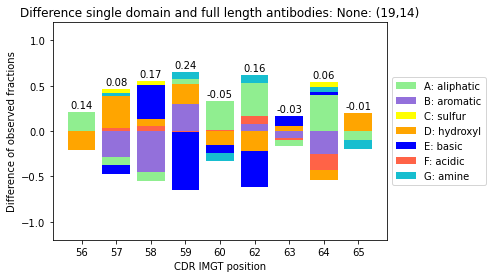

<IPython.core.display.Javascript object>

In [ ]:
#Plot difference between single domain and full length domain per IMGT number per canonical form
cdrs_interest = ['CDRH1', 'CDRH2']
for cdr_type in cdrs_interest:
    set_canonical_forms_nb = set(df_decomp_canonical_nb[f'{cdr_type}_canonicalform'])
    set_canonical_forms_fv = set(df_decomp_canonical_fv[f'{cdr_type}_canonicalform'])
    similar_canonical_forms = list(set_canonical_forms_nb & set_canonical_forms_fv)
    for canonical_form in similar_canonical_forms:
        df_canonical_nb = df_decomp_canonical_nb[df_decomp_canonical_nb[f'{cdr_type}_canonicalform'] == canonical_form]
        dict_stacked_info_cf_nb, cdr_position_type_dict_cf_nb = decomposition_per_imgt_position(df_canonical_nb, cdr_type.split(" "), binning_scheme)
        number_seq_nb = df_canonical_nb.shape[0]

        df_canonical_fv = df_decomp_canonical_fv[df_decomp_canonical_fv[f'{cdr_type}_canonicalform'] == canonical_form]
        dict_stacked_info_cf_fv, cdr_position_type_dict_cf_fv = decomposition_per_imgt_position(df_canonical_fv, cdr_type.split(" "), binning_scheme)
        number_seq_fv = df_canonical_fv.shape[0]

        #Determine mutual info score
        dict_position_mutualinfoscore = determine_mutual_info_score(cdr_position_type_dict_cf_nb, cdr_position_type_dict_cf_fv, dict_letter_to_number)

        #df_difference_nb_fv_cf = plot_difference(dict_stacked_info_cf_nb, dict_stacked_info_cf_fv, cdr_type.split(" "), binning_scheme, colour_palette_aa_group, "Difference single domain and full length antibodies", canonical_form = canonical_form, num_seq = [number_seq_nb, number_seq_fv])
        plot_differences_stacked(dict_stacked_info_cf_nb, dict_stacked_info_cf_fv, cdr_type.split(" "), binning_scheme, colour_palette_aa_group, "Difference single domain and full length antibodies", dict_position_mutualinfoscore, canonical_form = canonical_form, num_seq = [number_seq_nb, number_seq_fv]) 
